In [ ]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
from dotenv import load_dotenv
import pandas as pd
import os
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display_html

As we don't have access to professional musicians, or music industry experts to evaluate our songs and the project still in an early stage, we have developed an evaluation method inspired on Direct Preference Optimization (DPO). 

In the context of machine translation DPO consists of the evaluation of different translations of the same text using Large Language Models, this punctuation is used as a reward for fine-tuning the models. In our case, we have simply asked our model to evaluate in a score from one to ten according to different characteristics: coherence, musicality, and quality of the lyrics.

We have used Mistral's smallest model `open-mistral-7b` through API calls to obtain the scores and preprocessed the results. For those metrics that Mistral has not provided, we have assigned a negative value and filtered it later before doing the analysis.

# Metrics Extraction

In [3]:
load_dotenv()
MISTRAL_API = os.getenv("MISTRAL_API")
client = MistralClient(api_key=MISTRAL_API)

In [4]:
df = pd.read_csv("../data/reseted_test_predictions.csv")
df.head()

,index_x,artist,song,tag,Lyric,tag_2,True_end_lyrics,index_y,Generated Lyrics
0,0,5 Seconds of Summer,No Shame,[Verse 1: Luke],"Angel, with the gun in your hand",[Verse],"Pointin' my direction, givin' me affection Lov...",0,"Angel, with the gun in your hand, looking back..."
1,1,5 Seconds of Summer,No Shame,"[Pre-Chorus: Luke, Luke & Ashton]",Go on and light me like a cigarette,[Pre-Chorus],Even if it might be somethin' you regret You g...,1,Go on and light me like a cigarette as I am ma...
2,2,5 Seconds of Summer,No Shame,[Chorus: All],I only light up when cameras are flashin' Neve...,[Chorus],a reaction Changin' my face and callin' it fas...,2,I only light up when cameras are flashin' Neve...
3,3,5 Seconds of Summer,No Shame,[Verse 2: Luke],Lay me in the palm of your hand I'll give you ...,[Verse],somethin' sweeter than the words I left in you...,3,Lay me in the palm of your hand I'll give you ...
4,4,5 Seconds of Summer,No Shame,[Chorus: All],I only light up when cameras are flashin' Neve...,[Chorus],a reaction Changin' my face and callin' it fas...,4,I only light up when cameras are flashin' Neve...


In [5]:
df["Generated Lyrics"] = df["Generated Lyrics"].map(
    lambda x: x.replace("<|endoftext|>", "...")
)

In [ ]:
df["Original Lyrics"] = df["Lyric"] + " " + df["True_end_lyrics"]
data = df.sample(250, random_state=0)

In [8]:
def generate_prompt(tag, lyrics):
    return f"""ONLY THE SCORE.
    Give me the score from 0/10 coherence, musicality and quality. 
    Example: 
    coherence X/10
    musicality y/10
    quality z/10
    of this {tag} of a pop song: 
    {lyrics}"""

In [ ]:
original_promts = [
    generate_prompt(row["tag_2"], row["Original Lyrics"]) for _, row in data.iterrows()
]
generated_promts = [
    generate_prompt(row["tag_2"], row["Generated Lyrics"]) for _, row in data.iterrows()
]
generated_promts

In [10]:
def send_message_mistral(
    client: MistralClient, message: str, mistral_model="open-mistral-7b"
) -> str:
    """
    Send a message to the Mistral API and return the response.

    Parameters:
        client: Mistral API client.
        message: The message to send to the API.

    Returns:
        str: Model response.
    """
    messages = [ChatMessage(role="user", content=message)]
    chat_response = client.chat(
        model=mistral_model,
        messages=messages,
    )
    return chat_response.choices[0].message.content

In [11]:
send_message_mistral(client, "What is the best French cheese?")

'It\'s subjective to determine the "best" French cheese as it largely depends on personal preferences. Here are a few famous French cheeses that are widely appreciated for their distinct flavors and textures:\n\n1. Roquefort: A blue-veined cheese made from sheep\'s milk, originating from the Massif Central region in France. It\'s known for its strong, pungent aroma and tangy, savory taste.\n\n2. Camembert: A soft, creamy cheese with a white rind, originally from Normandy. It has a rich, earthy flavor with hints of mushroom and a slight tang.\n\n3. Comté: A nutty-tasting, firm cheese from the Franche-Comté region in eastern France. It has a complex, slightly sweet flavor with a smooth, buttery texture.\n\n4. Brie de Meaux: A soft, creamy cheese with a white, bloomy rind, produced in the Marne region. It has a mild, buttery flavor with hints of fresh cream and a slightly earthy aroma.\n\n5. Munster: A soft, smelly cheese with an orange rind, originating from the Alsace region. It has a s

In [12]:
original_eval = [send_message_mistral(client, prompt) for prompt in original_promts]
generated_eval = [send_message_mistral(client, prompt) for prompt in generated_promts]

In [16]:
data["Generated_eval"] = generated_eval
data["Original_eval"] = original_eval
data

,index_x,artist,song,tag,Lyric,tag_2,True_end_lyrics,index_y,Generated Lyrics,Original Lyrics,Generated_eval,Original_eval
453,559,Kesha,Take It Off,[Chorus],There's a place downtown where the freaks all ...,[Chorus],me on when they take it off When they take it ...,453,There's a place downtown where the freaks all ...,There's a place downtown where the freaks all ...,coherence: 8/10 (The lyrics follow a clear pat...,coherence: 7/10 (The lyrics follow a clear pat...
85,100,Bebe Rexha,The Way I Are (Dance with Somebody),[Chorus: Bebe Rexha],I just wanna dance with somebody I just wanna ...,[Chorus],are Just love me the way I are I just wanna da...,85,I just wanna dance with somebody I just wanna ...,I just wanna dance with somebody I just wanna ...,coherence: 6/10 (The lyrics are understandable...,coherence: 9/10 (The lyrics are clear and easy...
545,680,Meghan Trainor,Title,[Chorus],"Baby, don't call me your friend If I hear that...",[Chorus],hard to find But if you think you wanna try Th...,545,"Baby, don't call me your friend If I hear that...","Baby, don't call me your friend If I hear that...",coherence: 8/10 (The lyrics follow a clear the...,coherence: 7/10 (The lyrics follow a clear and...
312,382,Halsey,Bad at Love,[Bridge],I know that you're afraid I'm gonna walk away ...,[Bridge],fades Each time the feelin' fades I know that ...,312,I know that you're afraid I'm gonna walk away ...,I know that you're afraid I'm gonna walk away ...,coherence: 9/10 (The lyrics follow a clear and...,coherence: 10/10 (The lyrics clearly express a...
334,410,James Arthur,Naked,[Chorus],I'm not gonna wait until you're gone 'Cause yo...,[Chorus],pride) I'm standing here naked (I'm standing h...,334,I'm not gonna wait until you're gone 'Cause yo...,I'm not gonna wait until you're gone 'Cause yo...,coherence: 8/10 (The lyrics convey a clear mes...,coherence: 8/10 (The lyrics follow a clear the...
...,...,...,...,...,...,...,...,...,...,...,...,...
741,904,Troye Sivan,FOOLS,[Verse 2],"Oh, our lives dont collide, Im aware of this W...",[Verse],"like stick, and I like aerosol I dont give a f...",741,"Oh, our lives dont collide, Im aware of this W...","Oh, our lives dont collide, Im aware of this W...",coherence: 8/10 - The verse follows a logical ...,coherence: 8/10 (The lyrics follow a clear and...
188,226,Conan Gray,Maniac,[Pre-Chorus],People like you always want back what they can...,[Pre-Chorus],I'm past that and you know that So you should ...,188,People like you always want back what they can...,People like you always want back what they can...,coherence: 8/10 (The lyrics follow a clear and...,coherence: 8/10 (The lyrics follow a clear and...
350,432,Jason Derulo,Whatcha Say,[Chorus: Imogen Heap & Jason Derulo],"Mm, whatcha say? Oh, that you only meant well?...",[Chorus],"only meant well? Well, of course, you did Mm, ...",350,"Mm, whatcha say? Oh, that you only meant well?...","Mm, whatcha say? Oh, that you only meant well?...","coherence: 8/10 (The repetition of ""whatcha sa...",Coherence: 7/10 (The lyrics follow a clear pat...
596,745,One Direction,Story of My Life,[Verse 1: Harry & Liam],Written in these walls are the stories that I ...,[Verse],us in her bones It seems to me that when I die...,596,Written in these walls are the stories that I ...,Written in these walls are the stories that I ...,coherence: 9/10 (The lyrics follow a clear nar...,coherence: 8/10 (The verse follows a logical p...


In [29]:
import re

pattern = r"(\w+)\:\s+(\d+)\/(\d+)"
data["Generated_punct"] = data["Generated_eval"].map(
    lambda row: {x[0]: (float(x[1]), float(x[2])) for x in re.findall(pattern, row)}
)
data["Original_punct"] = data["Original_eval"].map(
    lambda row: {x[0]: (float(x[1]), float(x[2])) for x in re.findall(pattern, row)}
)

data.head()

,index_x,artist,song,tag,Lyric,tag_2,True_end_lyrics,index_y,Generated Lyrics,Original Lyrics,Generated_eval,Original_eval,Generated_punct,Original_punct
453,559,Kesha,Take It Off,[Chorus],There's a place downtown where the freaks all ...,[Chorus],me on when they take it off When they take it ...,453,There's a place downtown where the freaks all ...,There's a place downtown where the freaks all ...,coherence: 8/10 (The lyrics follow a clear pat...,coherence: 7/10 (The lyrics follow a clear pat...,"{'coherence': (8.0, 10.0), 'musicality': (7.0,...","{'coherence': (7.0, 10.0), 'musicality': (8.0,..."
85,100,Bebe Rexha,The Way I Are (Dance with Somebody),[Chorus: Bebe Rexha],I just wanna dance with somebody I just wanna ...,[Chorus],are Just love me the way I are I just wanna da...,85,I just wanna dance with somebody I just wanna ...,I just wanna dance with somebody I just wanna ...,coherence: 6/10 (The lyrics are understandable...,coherence: 9/10 (The lyrics are clear and easy...,"{'coherence': (6.0, 10.0), 'musicality': (8.0,...","{'coherence': (9.0, 10.0), 'musicality': (8.0,..."
545,680,Meghan Trainor,Title,[Chorus],"Baby, don't call me your friend If I hear that...",[Chorus],hard to find But if you think you wanna try Th...,545,"Baby, don't call me your friend If I hear that...","Baby, don't call me your friend If I hear that...",coherence: 8/10 (The lyrics follow a clear the...,coherence: 7/10 (The lyrics follow a clear and...,"{'coherence': (8.0, 10.0), 'musicality': (7.0,...","{'coherence': (7.0, 10.0), 'musicality': (8.0,..."
312,382,Halsey,Bad at Love,[Bridge],I know that you're afraid I'm gonna walk away ...,[Bridge],fades Each time the feelin' fades I know that ...,312,I know that you're afraid I'm gonna walk away ...,I know that you're afraid I'm gonna walk away ...,coherence: 9/10 (The lyrics follow a clear and...,coherence: 10/10 (The lyrics clearly express a...,"{'coherence': (9.0, 10.0), 'musicality': (8.0,...","{'coherence': (10.0, 10.0), 'musicality': (8.0..."
334,410,James Arthur,Naked,[Chorus],I'm not gonna wait until you're gone 'Cause yo...,[Chorus],pride) I'm standing here naked (I'm standing h...,334,I'm not gonna wait until you're gone 'Cause yo...,I'm not gonna wait until you're gone 'Cause yo...,coherence: 8/10 (The lyrics convey a clear mes...,coherence: 8/10 (The lyrics follow a clear the...,"{'coherence': (8.0, 10.0), 'musicality': (9.0,...","{'coherence': (8.0, 10.0), 'musicality': (7.0,..."


In [36]:
for data_set in ("Generated", "Original"):
    for att in ["coherence", "musicality", "quality"]:
        data[f"{data_set}_{att}"] = data[f"{data_set}_punct"].map(
            lambda x: 10 * x.get(att, (1, -1))[0] / x.get(att, (1, -1))[1]
        )

In [41]:
for data_set in ("Generated", "Original"):
    data[f"{data_set}_mean"] = data[
        [f"{data_set}_{att}" for att in ["coherence", "musicality", "quality"]]
    ].mean(axis=1)
data.head()

,index_x,artist,song,tag,Lyric,tag_2,True_end_lyrics,index_y,Generated Lyrics,Original Lyrics,...,Generated_punct,Original_punct,Generated_coherence,Generated_musicality,Generated_quality,Original_coherence,Original_musicality,Original_quality,Generated_mean,Original_mean
453,559,Kesha,Take It Off,[Chorus],There's a place downtown where the freaks all ...,[Chorus],me on when they take it off When they take it ...,453,There's a place downtown where the freaks all ...,There's a place downtown where the freaks all ...,...,"{'coherence': (8.0, 10.0), 'musicality': (7.0,...","{'coherence': (7.0, 10.0), 'musicality': (8.0,...",8.0,7.0,6.0,7.0,8.0,6.0,7.0,7.000000
85,100,Bebe Rexha,The Way I Are (Dance with Somebody),[Chorus: Bebe Rexha],I just wanna dance with somebody I just wanna ...,[Chorus],are Just love me the way I are I just wanna da...,85,I just wanna dance with somebody I just wanna ...,I just wanna dance with somebody I just wanna ...,...,"{'coherence': (6.0, 10.0), 'musicality': (8.0,...","{'coherence': (9.0, 10.0), 'musicality': (8.0,...",6.0,8.0,7.0,9.0,8.0,7.0,7.0,8.000000
545,680,Meghan Trainor,Title,[Chorus],"Baby, don't call me your friend If I hear that...",[Chorus],hard to find But if you think you wanna try Th...,545,"Baby, don't call me your friend If I hear that...","Baby, don't call me your friend If I hear that...",...,"{'coherence': (8.0, 10.0), 'musicality': (7.0,...","{'coherence': (7.0, 10.0), 'musicality': (8.0,...",8.0,7.0,6.0,7.0,8.0,6.0,7.0,7.000000
312,382,Halsey,Bad at Love,[Bridge],I know that you're afraid I'm gonna walk away ...,[Bridge],fades Each time the feelin' fades I know that ...,312,I know that you're afraid I'm gonna walk away ...,I know that you're afraid I'm gonna walk away ...,...,"{'coherence': (9.0, 10.0), 'musicality': (8.0,...","{'coherence': (10.0, 10.0), 'musicality': (8.0...",9.0,8.0,7.0,10.0,8.0,9.0,8.0,9.000000
334,410,James Arthur,Naked,[Chorus],I'm not gonna wait until you're gone 'Cause yo...,[Chorus],pride) I'm standing here naked (I'm standing h...,334,I'm not gonna wait until you're gone 'Cause yo...,I'm not gonna wait until you're gone 'Cause yo...,...,"{'coherence': (8.0, 10.0), 'musicality': (9.0,...","{'coherence': (8.0, 10.0), 'musicality': (7.0,...",8.0,9.0,7.0,8.0,7.0,7.0,8.0,7.333333


In [44]:
data.to_csv("../data/results_mistral.csv", index=False)

# Evaluation of Results


In [57]:
data = pd.read_csv(
    "../data/results_mistral.csv",
    usecols=[
        "artist",
        "song",
        "Lyric",
        "tag_2",
        "True_end_lyrics",
        "Generated Lyrics",
        "Original Lyrics",
        "Generated_coherence",
        "Generated_musicality",
        "Generated_quality",
        "Original_coherence",
        "Original_musicality",
        "Original_quality",
        "Generated_mean",
        "Original_mean",
    ],
).rename(columns={"tag_2": "tag"})
original_size = len(data)

We will filter those scores that are negative since this means that mistral has not scored the metric we asked.

In [170]:
metrics_col = [
    "Generated_coherence",
    "Original_coherence",
    "Generated_musicality",
    "Original_musicality",
    "Generated_quality",
    "Original_quality",
    "Generated_mean",
    "Original_mean",
]
data = data[data.apply(lambda x: all(x[col] > 0 for col in metrics_col), axis=1)]

We see that it is only a 18% of the total data.

In [171]:
(original_size - len(data)) / original_size * 100

18.4

## General Results

In [172]:
def plot_stats_by_tag(data, metric):
    generated_by_tag = (
        data[[f"Generated_{metric}", "tag"]].groupby("tag").mean().reset_index()
    )
    original_by_tag = (
        data[[f"Original_{metric}", "tag"]].groupby("tag").mean().reset_index()
    )

    merged_df = pd.merge(generated_by_tag, original_by_tag, on="tag")

    fig, ax = plt.subplots()

    bar_width = 0.35
    indices = merged_df.index
    ax.barh(
        indices - bar_width / 2,
        merged_df[f"Generated_{metric}"],
        bar_width,
        label="Generated",
    )
    ax.barh(
        indices + bar_width / 2,
        merged_df[f"Original_{metric}"],
        bar_width,
        label="Original",
    )

    ax.set_xlabel(f"{metric}")
    ax.set_ylabel("Tag")
    ax.set_title("Grouped Bar Chart")
    ax.set_xticks(indices)
    ax.set_yticks(indices)
    ax.set_yticklabels(merged_df["tag"])
    ax.legend()

    plt.show()

In [173]:
# Display several tables next side by side
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)

In [174]:
def get_stats_by_artist(data, metric):
    best_generated_artists = (
        data[[f"Generated_{metric}", "artist"]]
        .groupby("artist")
        .mean()
        .sort_values(by=[f"Generated_{metric}"])
        .sort_values(by=[f"Generated_{metric}"], ascending=False)
        .reset_index()
    )
    best_original_artists = (
        data[[f"Original_{metric}", "artist"]]
        .groupby("artist")
        .mean()
        .sort_values(by=[f"Original_{metric}"])
        .sort_values(by=[f"Original_{metric}"], ascending=False)
        .reset_index()
    )

    print(f"Stats of Generated Artists based on {metric} (Best vs Worst)")
    display_side_by_side(best_generated_artists[:5], best_generated_artists[-5:][::-1])
    print("")
    print(f"Stats of Original Artists based on {metric} (Best vs Worst)")
    display_side_by_side(best_original_artists[:5], best_original_artists[-5:][::-1])

In [175]:
data[metrics_col].describe().applymap(lambda x: f"{x:0.2f}")

/var/folders/b5/zsgbxty17rn21slqnmj3c2t00000gn/T/ipykernel_41371/506975616.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[metrics_col].describe().applymap(lambda x: f"{x:0.2f}")


,Generated_coherence,Original_coherence,Generated_musicality,Original_musicality,Generated_quality,Original_quality,Generated_mean,Original_mean
count,204.00,204.00,204.00,204.00,204.00,204.00,204.00,204.00
mean,8.04,8.31,7.75,7.81,7.11,7.34,7.63,7.82
std,1.05,0.84,0.76,0.73,1.18,1.05,0.73,0.58
min,3.00,5.00,5.00,6.00,2.00,5.00,3.33,6.00
25%,8.00,8.00,7.00,7.00,6.00,7.00,7.00,7.33
50%,8.00,8.00,8.00,8.00,7.00,7.00,8.00,8.00
75%,9.00,9.00,8.00,8.00,8.00,8.00,8.00,8.00
max,10.00,10.00,9.00,9.00,10.00,10.00,9.00,9.00


We can see that overall results are quite similar between the scores given to the Generated lyric and the original one. 
We can also see that Mistral is rather optimistic in most cases, since the average of most scores lies between 7 and 8, although there have been examples in which the scores have been very low as well.
In average (second row), we can see that the scores that refer to the original lyrics are always higher (even if slightlier) than the generated ones. This confirms our suspicion that our model could benefit from improvements.

It is observable that the minimum values of the original lyrics have a minimum score of 5, while the generated values of coherence and quality are 3 and 2 respectively. This is a sign that our model is not perfect but at the same time that our evaluator (Mistral) seems to be working well, since the original lyrics are human.

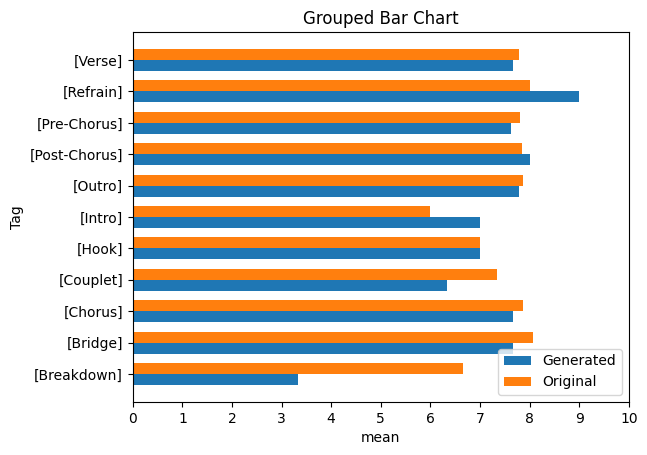

In [166]:
plot_stats_by_tag(data, "mean")

In general, all the stanzas seem to have similar average scores between generated and original lyrics. It is only the type `[Breakdown]` that seems to be quite far (almost half of the score) from the original lyrics. This can be due to the fact that we only have one sample of tagged as `[Breakdown]` so we are only relying on the score of one sample.

In [117]:
get_stats_by_artist(data, "mean")

Stats of Generated Artists based on mean (Best vs Worst)


,artist,Generated_mean
0,Lauv,9.000000
1,Phil Collins,9.000000
2,Calum Scott,8.666667
3,Whitney Houston,8.500000
4,Miley Cyrus,8.333333
,artist,Generated_mean
87,Glee Cast,5.000000
86,Jessie J,6.200000
85,Justin Timberlake,6.444444
84,Bazzi,6.444444



Stats of Original Artists based on mean (Best vs Worst)


,artist,Original_mean
0,Boyce Avenue,9.000000
1,Pentatonix,9.000000
2,Kelly Clarkson,8.666667
3,Camila Cabello,8.666667
4,Lady Gaga,8.666667
,artist,Original_mean
87,Jonas Brothers,7.0
86,Backstreet Boys,7.0
85,blackbear,7.0
84,Bastille,7.0


The best lyrics generated in average are those from these artists: Lauv, Phil Colins and Calum Scott. The worst ones are the Glee Cast, Jessie J and Justin Timberlake.
It is curious to see that the same scores from the original lyrics, are quite different. Therefore we can affirm that, in average, the results from the generated lyrics are not quite related to the average quality of the orginal ones.

## Coherence

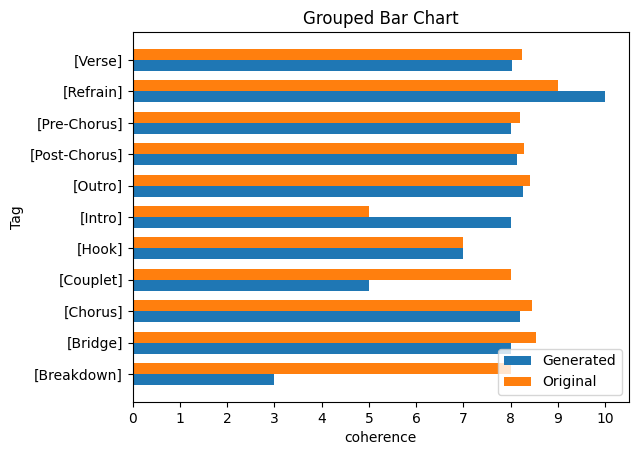

In [161]:
plot_stats_by_tag(data, "coherence")

In [112]:
get_stats_by_artist(data, "coherence")

Stats of Generated Artists based on coherence (Best vs Worst)


,artist,Generated_coherence
0,Phil Collins,10.0
1,Sam Smith,9.0
2,ABBA,9.0
3,Whitney Houston,9.0
4,Vance Joy,9.0
,artist,Generated_coherence
87,Glee Cast,5.0
86,Jessie J,5.8
85,Britney Spears,6.0
84,Céline Dion,6.0



Stats of Original Artists based on coherence (Best vs Worst)


,artist,Original_coherence
0,Boyce Avenue,10.000000
1,Pentatonix,10.000000
2,Halsey,9.333333
3,Harry Styles,9.250000
4,Bee Gees,9.000000
,artist,Original_coherence
87,Meghan Trainor,7.000000
86,Glee Cast,7.000000
85,Kehlani,7.000000
84,Justin Timberlake,7.333333


Phil Colins appears again as one of the best generated lyrics, this time based on coherence. While Glee Cast appears again in the top worst generated lyrics, based on coherence this time.
We can observe the big differences between the worst coherences in the generated lyrics against the originals: the worst coherences have values between 5 and 6, while the lowest coherence in the original lyrics doesn't go below 7. This might be an indicator of our model to be underfitted.

## Musicality

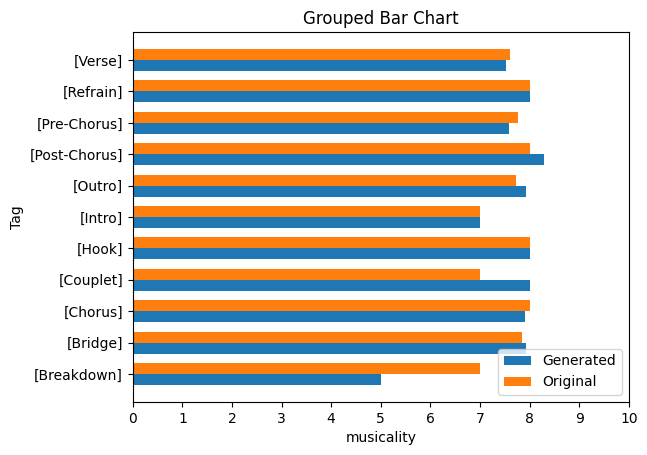

In [162]:
plot_stats_by_tag(data, "musicality")

In [111]:
get_stats_by_artist(data, "musicality")

Stats of Generated Artists based on musicality (Best vs Worst)


,artist,Generated_musicality
0,Nelly Furtado,9.0
1,Camila Cabello,9.0
2,Lady Gaga,9.0
3,Miley Cyrus,9.0
4,The Weeknd,9.0
,artist,Generated_musicality
87,MARINA,6.5
86,Ava Max,7.0
85,Bazzi,7.0
84,Alessia Cara,7.0



Stats of Original Artists based on musicality (Best vs Worst)


,artist,Original_musicality
0,Alec Benjamin,9.0
1,The Weeknd,9.0
2,Carly Rae Jepsen,9.0
3,Camila Cabello,9.0
4,Britney Spears,9.0
,artist,Original_musicality
87,Bastille,6.0
86,George Michael,6.0
85,Tom Odell,7.0
84,Jonas Brothers,7.0


Musicality seems to be the characteristic that the model has been able to capture the most or at least, the one that it struggles less with, since the scores are quite high and quite similar between the generated and original lyrics.

We can see that Nelly Furtado is on of the artist with higher musicality, so let's check it:

In [135]:
pprint(data[data.artist == "Nelly Furtado"]["Generated Lyrics"].iloc[0])

('Just a little look has got me feeling things Just a little touch has got me '
 'feeling things Just a little touch has got me feeling things Just a little '
 'touch has got me feeling things...')


In [136]:
pprint(data[data.artist == "Nelly Furtado"]["Original Lyrics"].iloc[0])

('Just a little look has got me feeling things Just a little touch has got me '
 'seeing things Just a little taste has got me off the chains Doing things '
 "that I don't wanna do")


And MARINA as one of the artists with less generated musicality:

In [137]:
pprint(data[data.artist == "MARINA"]["Generated Lyrics"].iloc[0])

("Mother Nature's dying, nobody's taking up the flowers\n"
 'Like a bullet from a bullet\n'
 "My morning love, my mama's forever mourning\n"
 'Your tears, my baby, my...')


In [138]:
pprint(data[data.artist == "MARINA"]["Original Lyrics"].iloc[0])

("Mother Nature's dying, nobody's keeping score I don't wanna live in a man's "
 "world anymore I don't wanna live in a man's world anymore")


* In terms of musicality, the model seems to be a bit biased towards considering the "repetition" resource as an indicator of musicality. This could be discussed, but specifically for pop songs, it is quite common to find this method.

## Quality

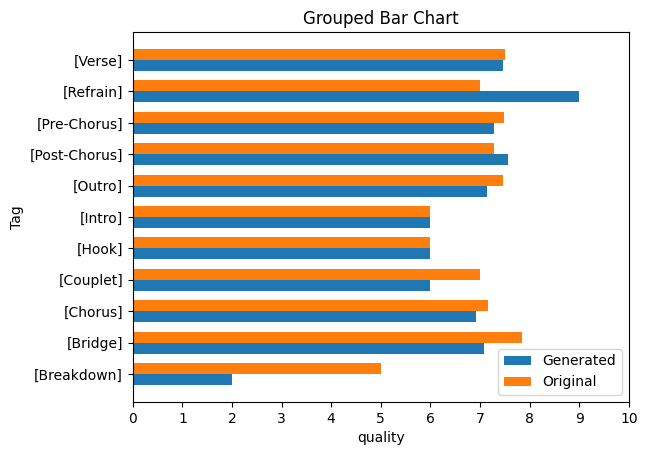

In [163]:
plot_stats_by_tag(data, "quality")

The quality seems to be quite balanced independently from the type of stanza. We observe again that the `[Breakdown]` tag is quite low in the generated lyrics, probably for the same reason. Let's take a look why:

In [183]:
data[data.tag == "[Refrain]"][metrics_col].T

,214
Generated_coherence,10.00
Original_coherence,9.00
Generated_musicality,8.00
Original_musicality,8.00
Generated_quality,9.00
Original_quality,7.00
Generated_mean,9.00
Original_mean,8.00


In [189]:
pprint(data[data.tag == "[Refrain]"]["Original Lyrics"].iloc[0])

("Money don't make me happy (make me happy) And a fella can't make me fancy "
 "(make me fancy) We smilin' for a whole 'nother reason (whole 'nother reason) "
 "It's all smiles through all four seasons")


In [188]:
pprint(data[data.tag == "[Refrain]"]["Generated Lyrics"].iloc[0])

("Money don't make me happy (make me happy) And a fella can't make me fancy "
 '(make me fancy) And I just need to know you can make me feel good...')


We can see that the generated version is more formal than the original one, it has less abbreviations and the lyrics sound more deep.

In [118]:
get_stats_by_artist(data, "quality")

Stats of Generated Artists based on quality (Best vs Worst)


,artist,Generated_quality
0,Lauv,10.0
1,James Blunt,9.0
2,Alessia Cara,9.0
3,Backstreet Boys,9.0
4,Ava Max,9.0
,artist,Generated_quality
87,Glee Cast,3.000000
86,Justin Timberlake,5.333333
85,MARINA,5.500000
84,Jessie J,5.800000



Stats of Original Artists based on quality (Best vs Worst)


,artist,Original_quality
0,Pentatonix,9.0
1,Calum Scott,9.0
2,Whitney Houston,9.0
3,Jess Glynne,9.0
4,Lady Gaga,9.0
,artist,Original_quality
87,Jonas Brothers,6.0
86,blackbear,6.0
85,Backstreet Boys,6.0
84,Glee Cast,6.0


The Glee Cast appears again as one of the top 5 worst generated lyrics, this time in terms of quality. Let's check how the best and worst generated lyrics compare to each other:

In [127]:
pprint(data[data.artist == "Lauv"]["Generated Lyrics"].iloc[0])

('Is my love too much? Or are my words not so caring?\n'
 'I just want you to know that I love you too much\n'
 'I just want you to know that I love...')


In [131]:
pprint(data[data.artist == "Lauv"]["Original Lyrics"].iloc[0])

("Is my love too much? Or is it just enough for you, for you? 'Cause it's "
 "gettinglate,would you liketo stay? Ah 'Cause I'm bad atreading signs")


In [126]:
pprint(data[data.artist == "Glee Cast"]["Generated Lyrics"].iloc[0])

("(Pa, pa, pa, pa, pa, pa, pa, pa) Valerie-e-e (Why don't you come on over?) "
 '(Pa, pa, pa, pa, pa, pa, pa, pa, pa, pa, pa, pa) Valerie-e-e (If you let me '
 'come on over) (Pa, pa, pa...')


In [130]:
pprint(data[data.artist == "Glee Cast"]["Original Lyrics"].iloc[0])

("(Pa, pa, pa, pa, pa, pa, pa, pa) Valerie-e-e (Why don't you come on over?) "
 '(Pa, pa, pa, pa, pa, pa, pa, pa) Va-a-lerie yeah (Valerie, Valerie) (Pa, pa, '
 "pa, pa, pa, pa, pa, pa) Valerie-e-e (Why don't you come on over?)")


We can see that the lyrics for the Glee Cast are plain and syllables being repeated, which does not represent a big quality.

# Check your favorite Artist

Here we provide a code for the user to check the metrics of the generated lyrics and original ones of their favorite artists.

In [148]:
def get_stats_from_artist(df, artist):
    return df[df.artist == artist][metrics_col].mean().T

In [149]:
get_stats_from_artist(data, "Taylor Swift")

Generated_coherence     8.000000
Generated_musicality    8.000000
Generated_quality       7.500000
Original_coherence      8.000000
Original_musicality     8.000000
Original_quality        8.000000
Generated_mean          7.833333
Original_mean           8.000000
dtype: float64

# Conclusions

* We have used Mistral to score three characteristics of the lyrics: quality, musicality and coherence. We have compared the scores given to both: the generated lyrics and the original ones. This technique has proven to be helpful and easy to implement.
* In general, we have observed that the average values for the generated quality, musicality and coherence of the lyrics are very close to the original ones, however the generated lyrics have lower scores than the original ones. This could indicate that we might benefit from further training and/or data augmentation.
* We haven't found significant differences or specially good performances in specific tags (types of stanza). However, a bigger corpus and more samples from each of the tags would benefit the conclusions of the analysis (for instance, we only had one sample for the tag `[Breakdown]`).
* In terms of artists, `Glee Cast` is in the top 5 worst generated lyrics in musicality and coherence with very low scores, what leads to the lowest average scores in average.
* In terms of musicality, the model seems to be a bit biased towards considering the "repetition" resource as an indicator of musicality. This could be discussed, but specifically for pop songs, it is quite common to find this method.
* For more generalisable results that are specific for stanza or artist, it would be better to analyze more than one song per artist. We include this as future improvements since the time and computational resources were limited.